In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Data Loading

In [2]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/config_fold3.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/config_fold3.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: Disabled
Strategy: memory

📊 Data Splits:
  Train: 33 samples
  Val: 9 samples
  Test: 8 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 0
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.0

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: False
Batch Size: 4
Num Workers: 0

Train split: 27 CRC + 6 Xenium samples
Val split: 7 CRC + 2 Xenium samples
Test split: 7 CRC + 1 Xenium samples

📊 Building patch index for 33 samples...
  ✅ CRC08 (CRC): 115 patches
  ✅ CRC09 (CRC): 57 patches
  ✅ CRC10 (CRC): 27 patches
  ✅ CRC11 (CRC): 13 patches
  ✅ CRC12 (CRC): 69 patches
  ✅ CRC13 (CRC): 38 patches
  ✅ C

## Flex Metrics

Using device: cuda
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
Processing sample 0: CRC15, patch 0

📊 BINARY SEGMENTATION METRICS
Nuclei - Dice: 0.8647, IoU: 0.7616
Cell   - Dice: 0.9007, IoU: 0.8193

📊 INSTANCE METRICS
Nuclei - PQ: 0.6907, AJI: 0.6939, Count: 260
Cell   - PQ: 0.6157, AJI: 0.5062, Count: 298


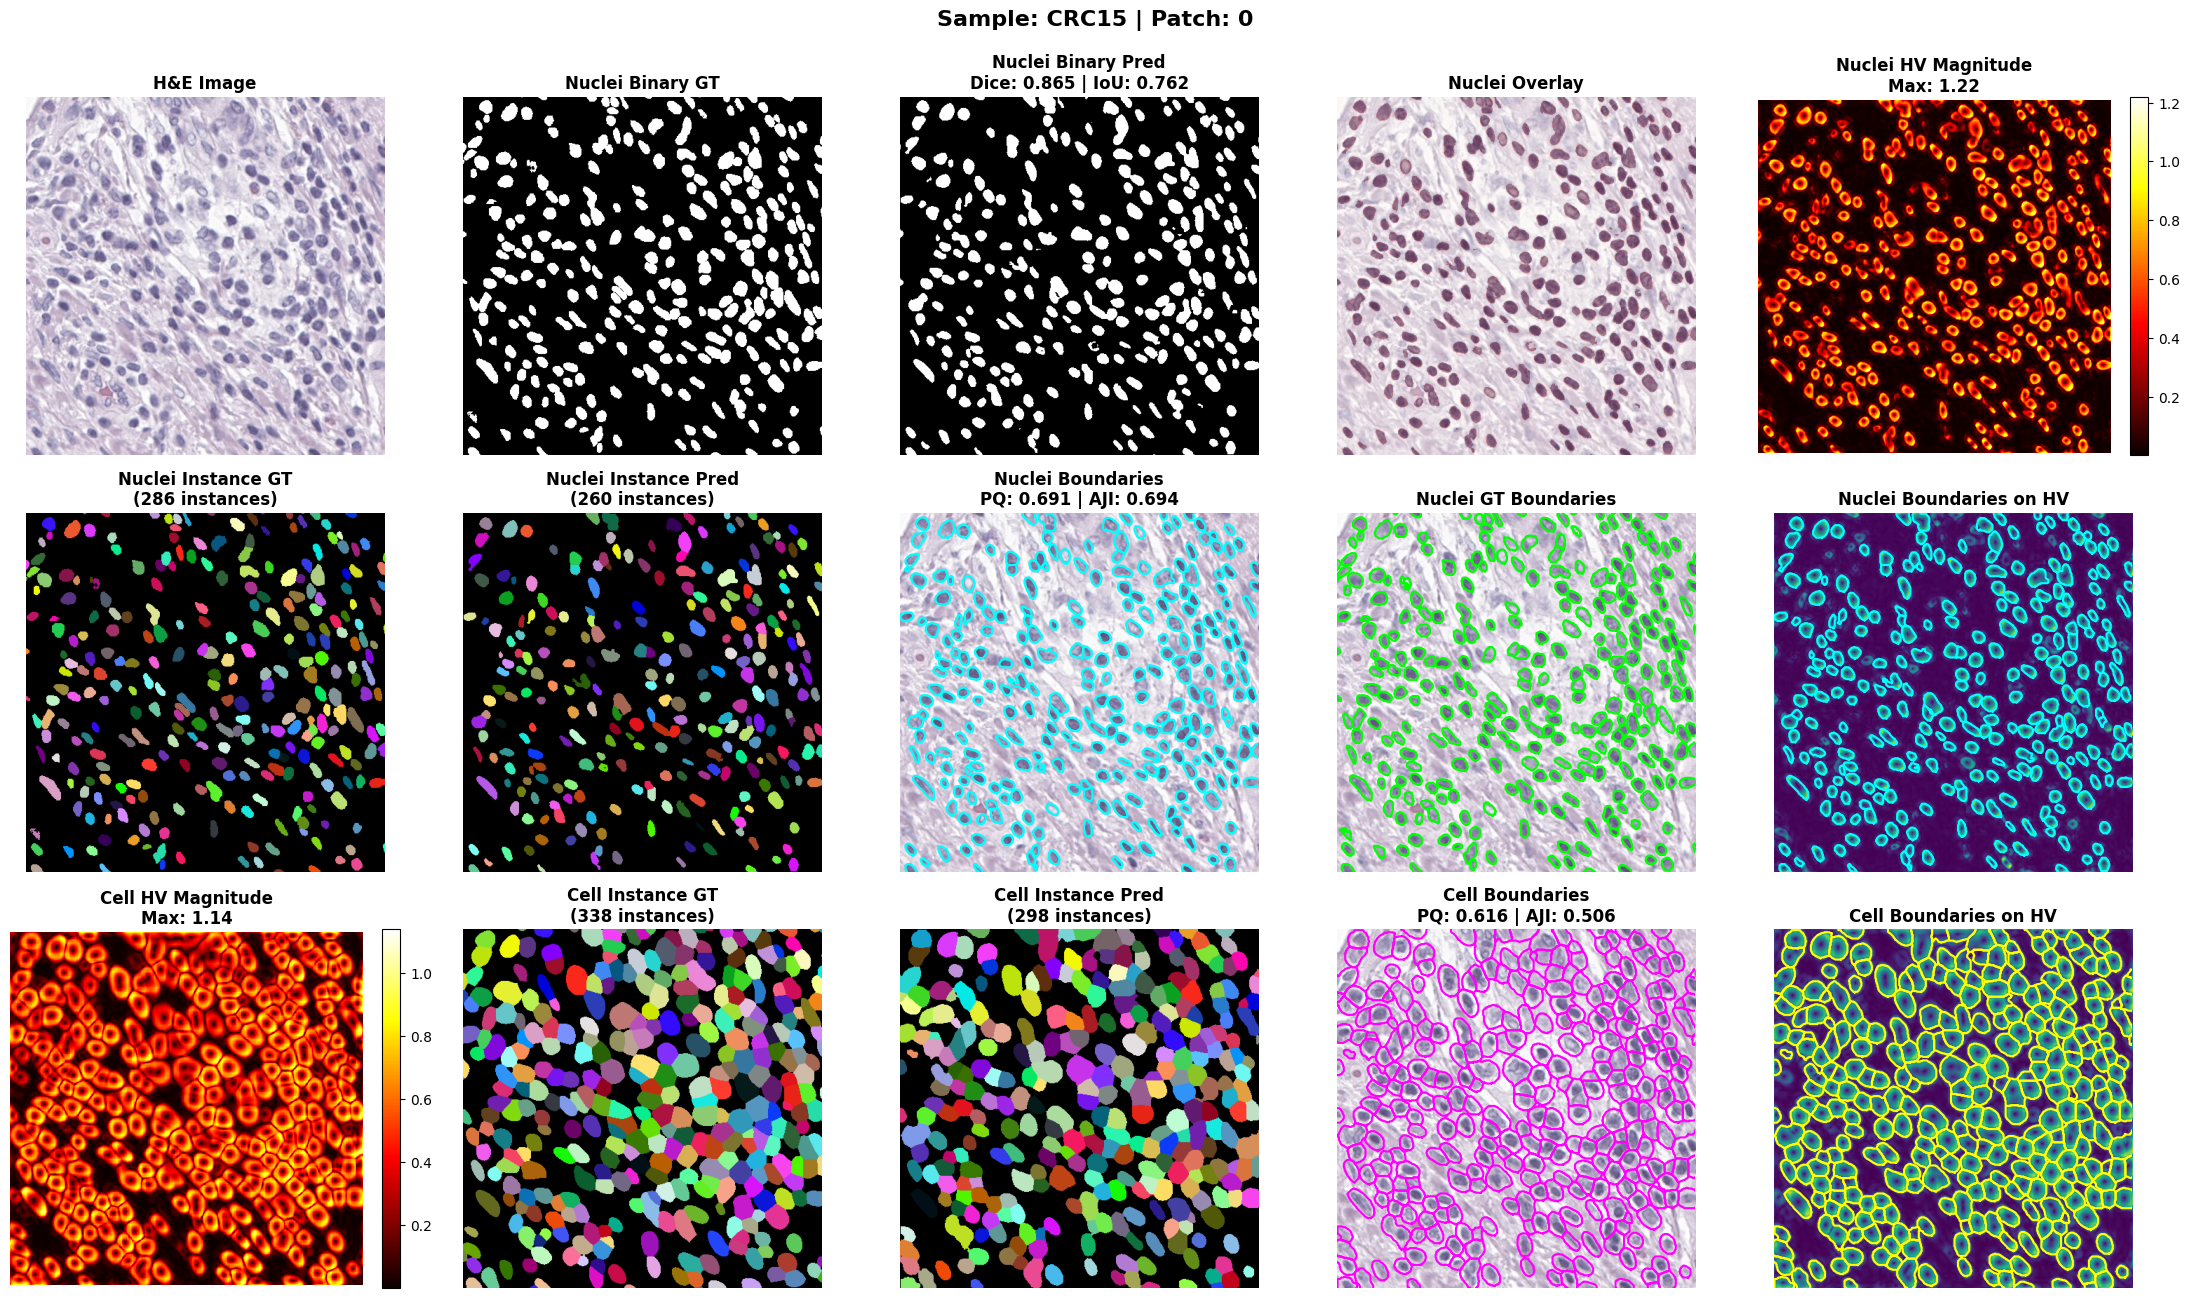

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from metrics import (dice_coefficient, iou_score, precision_score, recall_score,
                     f1_score, panoptic_quality, aggregated_jaccard_index)
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs
from skimage import measure

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold3_best.pth", map_location=device))
model.eval()
preprocessor = SimplePreprocessing()

# ========== SELECT SAMPLE BY INDEX ==========
SAMPLE_IDX = 0  # 🎯 CHANGE THIS TO SELECT YOUR SAMPLE

batch = test_loader.dataset[SAMPLE_IDX]

# Get sample info before adding batch dimension
sample_name = batch['sample_name'] if isinstance(batch['sample_name'], str) else batch['sample_name']
patch_idx = batch['patch_idx'].item() if isinstance(batch['patch_idx'], torch.Tensor) else batch['patch_idx']

# Add batch dimension
for key in batch.keys():
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].unsqueeze(0)

print(f"Processing sample {SAMPLE_IDX}: {sample_name}, patch {patch_idx}")

# Inference
he_img = prepare_he_input(batch['he_image'].to(device))
he_img = preprocessor.percentile_normalize(he_img)

nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
nuclei_inst_gt = batch['he_nuclei_instance'][0].cpu().numpy()
cell_inst_gt = batch['he_cell_instance'][0].cpu().numpy()

with torch.no_grad():
    outputs = model(he_img)

pred_nuclei = (outputs['he_nuclei_seg'] > 0.5).float()
pred_cell = (outputs['he_cell_seg'] > 0.5).float()

# ========== METRICS ==========
print("\n📊 BINARY SEGMENTATION METRICS")
nuclei_dice = dice_coefficient(pred_nuclei, nuclei_mask_gt)
nuclei_iou = iou_score(pred_nuclei, nuclei_mask_gt)
cell_dice = dice_coefficient(pred_cell, cell_mask_gt)
cell_iou = iou_score(pred_cell, cell_mask_gt)

print(f"Nuclei - Dice: {nuclei_dice:.4f}, IoU: {nuclei_iou:.4f}")
print(f"Cell   - Dice: {cell_dice:.4f}, IoU: {cell_iou:.4f}")

# ========== INSTANCE SEGMENTATION ==========
nuclei_seg_np = outputs['he_nuclei_seg'][0, 0].cpu().numpy()
nuclei_h_map = outputs['he_nuclei_hv'][0, 0].cpu().numpy()
nuclei_v_map = outputs['he_nuclei_hv'][0, 1].cpu().numpy()
cell_seg_np = outputs['he_cell_seg'][0, 0].cpu().numpy()
cell_h_map = outputs['he_cell_hv'][0, 0].cpu().numpy()
cell_v_map = outputs['he_cell_hv'][0, 1].cpu().numpy()

nuclei_hv_magnitude = np.sqrt(nuclei_h_map**2 + nuclei_v_map**2)
cell_hv_magnitude = np.sqrt(cell_h_map**2 + cell_v_map**2)

nuclei_inst_pred, _, num_nuclei = process_model_outputs(nuclei_seg_np, nuclei_h_map, nuclei_v_map, magnification=40)
cell_inst_pred, _, num_cells = process_model_outputs(cell_seg_np, cell_h_map, cell_v_map, magnification=40)

nuclei_pq = panoptic_quality(nuclei_inst_gt, nuclei_inst_pred)
nuclei_aji = aggregated_jaccard_index(nuclei_inst_gt, nuclei_inst_pred)
cell_pq = panoptic_quality(cell_inst_gt, cell_inst_pred)
cell_aji = aggregated_jaccard_index(cell_inst_gt, cell_inst_pred)

print(f"\n📊 INSTANCE METRICS")
print(f"Nuclei - PQ: {nuclei_pq:.4f}, AJI: {nuclei_aji:.4f}, Count: {num_nuclei}")
print(f"Cell   - PQ: {cell_pq:.4f}, AJI: {cell_aji:.4f}, Count: {num_cells}")

# ========== VISUALIZATION ==========
def colorize_instance_map(instance_map):
    colored = np.zeros((*instance_map.shape, 3), dtype=np.uint8)
    instance_ids = np.unique(instance_map)[1:]  # Remove background
    np.random.seed(42)
    for inst_id in instance_ids:
        colored[instance_map == inst_id] = np.random.randint(0, 255, 3)
    return colored

def draw_instance_boundaries(ax, img, instance_map, color='red', linewidth=1.5):
    ax.imshow(img)
    for inst_id in np.unique(instance_map)[1:]:
        mask = (instance_map == inst_id).astype(np.uint8)
        for contour in measure.find_contours(mask, 0.5):
            ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

fig, axes = plt.subplots(3, 5, figsize=(22, 13))
he_vis = batch['he_image'][0].permute(1, 2, 0).cpu().numpy()
nuclei_gt_vis = nuclei_mask_gt[0, 0].cpu().numpy()
nuclei_pred_vis = pred_nuclei[0, 0].cpu().numpy()

fig.suptitle(f'Sample: {sample_name} | Patch: {patch_idx}', fontsize=16, fontweight='bold', y=0.995)

# Row 1: Nuclei Binary + HV
axes[0, 0].imshow(he_vis); axes[0, 0].set_title('H&E Image', fontweight='bold'); axes[0, 0].axis('off')
axes[0, 1].imshow(nuclei_gt_vis, cmap='gray'); axes[0, 1].set_title('Nuclei Binary GT', fontweight='bold'); axes[0, 1].axis('off')
axes[0, 2].imshow(nuclei_pred_vis, cmap='gray'); axes[0, 2].set_title(f'Nuclei Binary Pred\nDice: {nuclei_dice:.3f} | IoU: {nuclei_iou:.3f}', fontweight='bold'); axes[0, 2].axis('off')
axes[0, 3].imshow(he_vis); axes[0, 3].imshow(nuclei_pred_vis, cmap='Reds', alpha=0.3); axes[0, 3].set_title('Nuclei Overlay', fontweight='bold'); axes[0, 3].axis('off')
im1 = axes[0, 4].imshow(nuclei_hv_magnitude, cmap='hot'); axes[0, 4].set_title(f'Nuclei HV Magnitude\nMax: {nuclei_hv_magnitude.max():.2f}', fontweight='bold'); axes[0, 4].axis('off')
plt.colorbar(im1, ax=axes[0, 4], fraction=0.046)

# Row 2: Nuclei Instance
axes[1, 0].imshow(colorize_instance_map(nuclei_inst_gt)); axes[1, 0].set_title(f'Nuclei Instance GT\n({len(np.unique(nuclei_inst_gt))-1} instances)', fontweight='bold'); axes[1, 0].axis('off')
axes[1, 1].imshow(colorize_instance_map(nuclei_inst_pred)); axes[1, 1].set_title(f'Nuclei Instance Pred\n({num_nuclei} instances)', fontweight='bold'); axes[1, 1].axis('off')
draw_instance_boundaries(axes[1, 2], he_vis, nuclei_inst_pred, 'cyan', 1.5); axes[1, 2].set_title(f'Nuclei Boundaries\nPQ: {nuclei_pq:.3f} | AJI: {nuclei_aji:.3f}', fontweight='bold'); axes[1, 2].axis('off')
draw_instance_boundaries(axes[1, 3], he_vis, nuclei_inst_gt, 'lime', 1.5); axes[1, 3].set_title('Nuclei GT Boundaries', fontweight='bold'); axes[1, 3].axis('off')
draw_instance_boundaries(axes[1, 4], nuclei_hv_magnitude, nuclei_inst_pred, 'cyan', 1.5); axes[1, 4].set_title('Nuclei Boundaries on HV', fontweight='bold'); axes[1, 4].axis('off')

# Row 3: Cell Instance + HV
im2 = axes[2, 0].imshow(cell_hv_magnitude, cmap='hot'); axes[2, 0].set_title(f'Cell HV Magnitude\nMax: {cell_hv_magnitude.max():.2f}', fontweight='bold'); axes[2, 0].axis('off')
plt.colorbar(im2, ax=axes[2, 0], fraction=0.046)
axes[2, 1].imshow(colorize_instance_map(cell_inst_gt)); axes[2, 1].set_title(f'Cell Instance GT\n({len(np.unique(cell_inst_gt))-1} instances)', fontweight='bold'); axes[2, 1].axis('off')
axes[2, 2].imshow(colorize_instance_map(cell_inst_pred)); axes[2, 2].set_title(f'Cell Instance Pred\n({num_cells} instances)', fontweight='bold'); axes[2, 2].axis('off')
draw_instance_boundaries(axes[2, 3], he_vis, cell_inst_pred, 'magenta', 1.5); axes[2, 3].set_title(f'Cell Boundaries\nPQ: {cell_pq:.3f} | AJI: {cell_aji:.3f}', fontweight='bold'); axes[2, 3].axis('off')
draw_instance_boundaries(axes[2, 4], cell_hv_magnitude, cell_inst_pred, 'yellow', 1.5); axes[2, 4].set_title('Cell Boundaries on HV', fontweight='bold'); axes[2, 4].axis('off')

plt.tight_layout()
plt.show()